This script accesses PMW data from NSIDC for 2023 and pairs that with visual data for 2023

In [35]:
# import libraries

import earthaccess
import xarray as xr
import dask
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio import features
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, Transformer
from pathlib import Path
import glob
import fnmatch

# colormap for plotting sea ice throughout rest of project

cmap = plt.get_cmap("Blues_r").copy()
cmap.set_bad(color='lightgray')

# authenticate NASA earth access

auth = earthaccess.login(strategy='interactive', persist = True)

In [36]:
# search NASA database for Team

results = earthaccess.search_data(
    short_name= 'NSIDC-0051',
    temporal=('2023-01-01', '2023-12-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

import re
filtered_results = [
    g for g in results
    if re.search(r'_20\d{6}_', g.data_links(access='external')[0])
]

print(f"We found {len(results)} results matching your parameters, and filtered them down to {len(filtered_results)} by removing monthly averages")

We found 377 results matching your parameters, and filtered them down to 365 by removing monthly averages


In [37]:
# get files from NSIDC

files_team = earthaccess.open(filtered_results)

QUEUEING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/365 [00:00<?, ?it/s]

In [38]:
# search NASA database for Bootstrap

results = earthaccess.search_data(
    short_name= 'NSIDC-0079',
    temporal=('2023-01-01', '2023-12-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

filtered_results = [
    g for g in results
    if re.search(r'_20\d{6}_', g.data_links(access='external')[0])
]

print(f"We found {len(results)} results matching your parameters, and filtered them down to {len(filtered_results)} by removing monthly averages")

We found 377 results matching your parameters, and filtered them down to 365 by removing monthly averages


In [39]:
# get files from NSIDC

files_bootstrap = earthaccess.open(filtered_results)

QUEUEING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/365 [00:00<?, ?it/s]

In [40]:
# stream team into xarray

ds = xr.open_mfdataset(files_team, parallel = True, concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override')

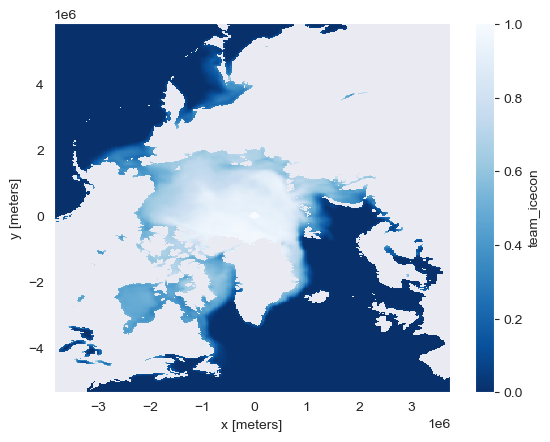

In [41]:
# change ice concentration variable to something universal

icecon_vars = sorted([var for var in ds.data_vars if 'ICECON'in var], reverse=True)
icecon = ds[icecon_vars].to_array("source").max("source", skipna=True)

# add back to dataset and clean up
ds = ds.assign(team_icecon=icecon).drop_vars(icecon_vars)

# print dataset and plot just to check this works
ds.team_icecon.where(ds.team_icecon < 1.01).mean(dim='time').plot(cmap='Blues_r')

In [42]:
# stream bootstrap into xarray
ds_bootstrap = xr.open_mfdataset(files_bootstrap, parallel = True, concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override')

<xarray.Dataset> Size: 795MB
Dimensions:           (x: 304, y: 448, time: 365)
Coordinates:
  * x                 (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                 (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
Data variables:
    crs               |S1 1B ...
    team_icecon       (time, y, x) float64 398MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    bootstrap_icecon  (time, y, x) float64 398MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https:/

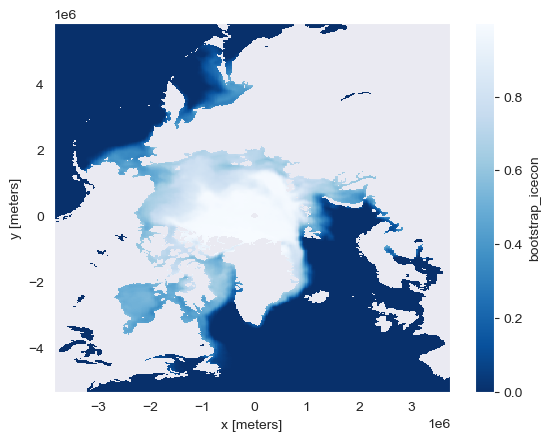

In [43]:
# change ice concentration variable to something universal

icecon_vars = sorted([var for var in ds_bootstrap.data_vars if 'ICECON'in var], reverse=True)
icecon = ds_bootstrap[icecon_vars].to_array("source").max("source", skipna=True)

# add back to dataset and clean up
ds = ds.assign(bootstrap_icecon=icecon)

# and plot just to check this works
ds.bootstrap_icecon.where(ds.bootstrap_icecon < 1.01).mean(dim='time').plot(cmap='Blues_r')
print(ds)

In [44]:
# read in land file from geopandas and initialize transform (from NSIDC metadata)

land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)
transform = [25000, 0, -3830000, 0, -25000, 5830000]

# ASK ALICE other transform  = transform = [25000, 0, -3837500, 0, -25000, 5837500] Which One????
# from this: 
# dx = float(ds.x.diff('x').mean())
# dy = float(ds.y.diff('y').mean())
# x0 = float(ds.x.min())
# y0 = float(ds.y.max())
# transform = [dx, 0, x0, 0, -abs(dy), y0]

# use transform to mask out coastal cells

land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(448, 304),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# calculate distance from land using euclidian distance transform

distance_from_land = distance_transform_edt(land_mask == 0)

# convert to xarray.DataArray

distance_xr = xr.DataArray(
    distance_from_land,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x'),
    name='distance_to_land_cells'
)

# add as data variable in ds

ds['edtl'] = distance_xr
print(ds)

<xarray.Dataset> Size: 796MB
Dimensions:           (x: 304, y: 448, time: 365)
Coordinates:
  * x                 (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                 (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
Data variables:
    crs               |S1 1B ...
    team_icecon       (time, y, x) float64 398MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    bootstrap_icecon  (time, y, x) float64 398MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    edtl              (y, x) float64 1MB 106.0 105.1 104.2 ... 15.3 15.52 15.81
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These da

In [45]:
# read in files

folderpath = '../local_data/visual_ice/'
paths = Path(folderpath).glob('*2023*.csv')
pathlist = list(paths)
pathlist

[PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023e_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023d_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023b_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023c_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023h_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023a.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023f_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_w90w100_2023b_LC08.csv'),
 PosixPath('../local_data/visual_ice/big_array_coast_cell_smallest_2023_LC08.csv')]

In [46]:
# data cleaning of visual datasets

visual = pd.concat(map(pd.read_csv, pathlist), ignore_index=True)

# convert things for xarray

row_to_lat = dict(enumerate(ds['x'].values))
col_to_lon = dict(enumerate(ds['y'].values))
visual["time"] = pd.to_datetime(visual["Date"], yearfirst=True)

visual['Row'] = visual['Row'] - 1
visual['Column'] = visual['Column'] - 1
visual['x'] = visual['Row'].map(row_to_lat)
visual['y'] = visual['Column'].map(col_to_lon)
visual = visual.drop_duplicates(subset=["time", "x", "y"])

# convert pandas dataframe of visual things into chunked xarray dataset on time, lat, and lon

da_sparse = visual.set_index(['time', 'y', 'x']).to_xarray()
da_full = da_sparse.reindex_like(ds, method=None)
da_full = da_full.chunk({'time': 2})
da_full

# assign visual data to the NASA team dataset and sanity check plot

ds = ds.assign(**{'visual_ice': da_full['SI frac']})
print(ds)

<xarray.Dataset> Size: 1GB
Dimensions:           (x: 304, y: 448, time: 365)
Coordinates:
  * x                 (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                 (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
Data variables:
    crs               |S1 1B ...
    team_icecon       (time, y, x) float64 398MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    bootstrap_icecon  (time, y, x) float64 398MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    edtl              (y, x) float64 1MB 106.0 105.1 104.2 ... 15.3 15.52 15.81
    visual_ice        (time, y, x) float64 398MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:        

<Figure size 640x480 with 0 Axes>

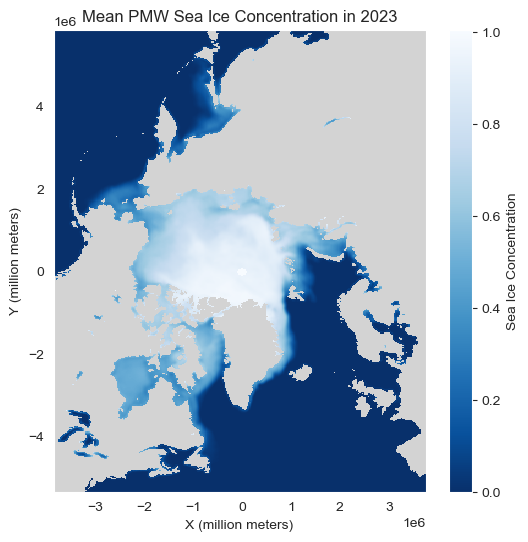

In [47]:
# sanity check one

sns.set_style('darkgrid')
sns.despine()

ds_subset = ds.where(ds.team_icecon < 1.01)
ax = ds_subset.team_icecon.mean(dim='time').plot(
    cmap=cmap,
    cbar_kwargs={'label': 'Sea Ice Concentration'},
    figsize=(6,6)
)

plt.title("Mean PMW Sea Ice Concentration in 2023")
plt.xlabel("X (million meters)")
plt.ylabel("Y (million meters)")
plt.show()

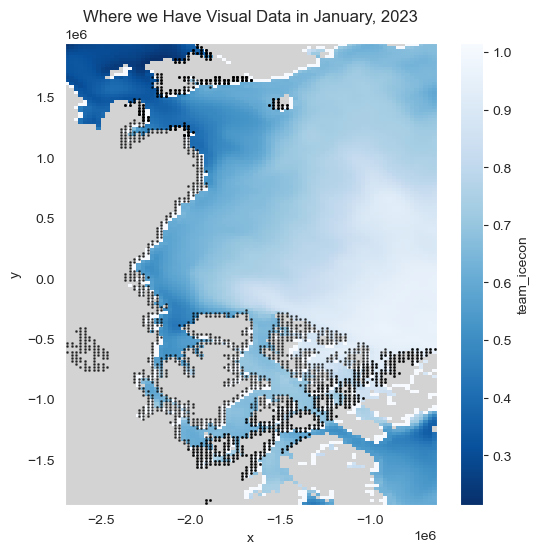

In [48]:
# sanity check two

x_min, x_max = visual['x'].min(), visual['x'].max()
y_min, y_max = visual['y'].min(), visual['y'].max()

ds_subset = ds.sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).where(ds.edtl > 0)
ax = ds_subset.team_icecon.mean(dim='time').plot(
    cmap=cmap,
    figsize=(6,6)
)

plt.scatter(
    visual['x'],
    visual['y'],
    color='black',
    s=1,
    alpha=0.6
)
plt.title("Where we Have Visual Data in January, 2023")
plt.show()

In [ ]:
# Error for NASA Team

condition = ((ds.visual_ice.notnull()) & (ds.team_icecon < 1.01))
ds_clean = ds.where(condition, other=np.nan).compute()

In [57]:
# error calculation team

error_team = ((((ds_clean['team_icecon'] - ds_clean['visual_ice']))**2)**0.5)
error_avg = error_team.mean(dim=['time', 'x', 'y'], skipna=True)
print('RMS error for NASA Team is', error_avg.compute().item())

RMS error for NASA Team is 0.4507627678212574


In [58]:
# save a data cleaned pandas dataframe for team with everything (1.012 = coast, 1.016 = land)

df = ds_clean.to_dataframe().reset_index()
df

,time,y,x,crs,team_icecon,bootstrap_icecon,edtl,visual_ice
0,2023-01-01,5837500.0,-3837500.0,NaN,NaN,NaN,NaN,NaN
1,2023-01-01,5837500.0,-3812500.0,NaN,NaN,NaN,NaN,NaN
2,2023-01-01,5837500.0,-3787500.0,NaN,NaN,NaN,NaN,NaN
3,2023-01-01,5837500.0,-3762500.0,NaN,NaN,NaN,NaN,NaN
4,2023-01-01,5837500.0,-3737500.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
49710075,2023-12-31,-5337500.0,3637500.0,NaN,NaN,NaN,NaN,NaN
49710076,2023-12-31,-5337500.0,3662500.0,NaN,NaN,NaN,NaN,NaN
49710077,2023-12-31,-5337500.0,3687500.0,NaN,NaN,NaN,NaN,NaN
49710078,2023-12-31,-5337500.0,3712500.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Error for NASA Bootstrap

condition = ((ds.visual_ice.notnull()) & (ds.bootstrap_icecon < 1.01))
ds_clean = ds.where(condition, other=np.nan).compute()

In [60]:
# error calculation bootstrap

error_bootstrap = ((((ds_clean['bootstrap_icecon'] - ds_clean['visual_ice']))**2)**0.5)
error_avg = error_bootstrap.mean(dim=['time', 'x', 'y'], skipna=True)
print('RMS error for NASA Bootstrap is', error_avg.compute().item())

RMS error for NASA Bootstrap is 0.4806965067017712


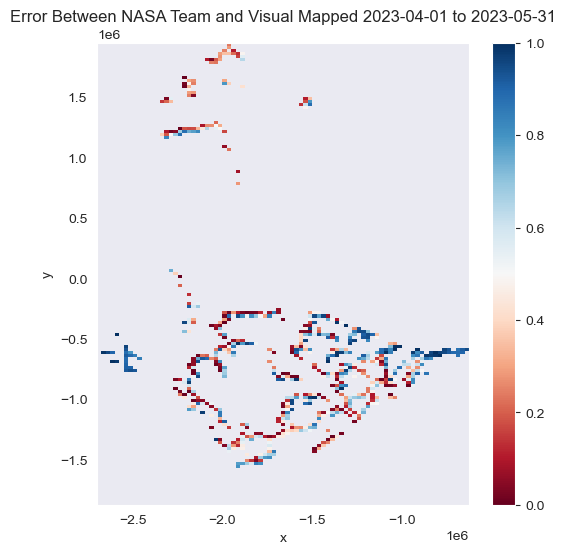

In [61]:
# map error NASA team

sns.set_style('darkgrid')
error_subset = error_team.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))
ax = error_subset.mean(dim='time', skipna=True).plot(cmap = 'RdBu', figsize=(6,6))
plt.title("Error Between NASA Team and Visual Mapped 2023-04-01 to 2023-05-31")
plt.show()

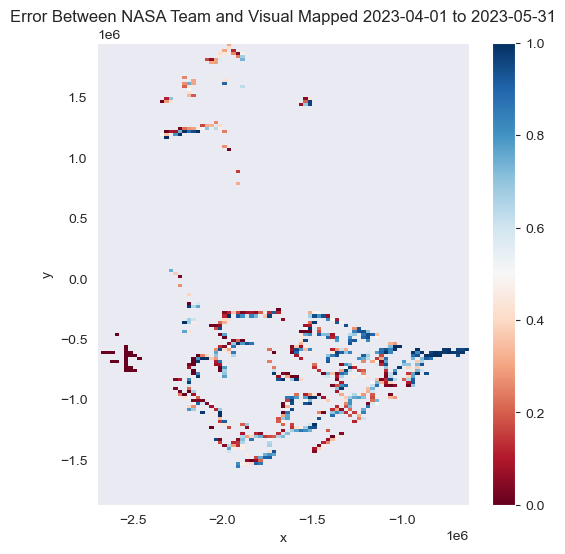

In [62]:
# map error NASA bootstrap

error_subset = error_bootstrap.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))
ax = error_subset.mean(dim='time', skipna=True).plot(cmap = 'RdBu', figsize=(6,6))
plt.title("Error Between NASA Team and Visual Mapped 2023-04-01 to 2023-05-31")
plt.show()

In [55]:
# save a data cleaned pandas dataframe for boostrap with everything (1.012 = coast, 1.016 = land)

df = ds_clean.to_dataframe().reset_index().dropna()